In [1]:
import os
import sys
import warnings
import numpy as np

sys.path.append(os.path.dirname(os.getcwd()))
warnings.filterwarnings('ignore')

In [3]:
import geomstats.backend as gs
import geomstats.tests
import geomstats.visualization as visualization
import geomstats.datasets.utils as data_utils

from geomstats.geometry.hypersphere import Hypersphere, HypersphereMetric
from geomstats.geometry.special_orthogonal import SpecialOrthogonal
from geomstats.learning.frechet_mean import FrechetMean
from geomstats.learning.riemannian_mean_shift import RiemannianMeanShift
from geomstats.geometry.pre_shape import KendallShapeMetric, PreShapeSpace
from geomstats.visualization import KendallDisk, KendallSphere
from sklearn.metrics import confusion_matrix

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.image as mpimg
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

# Applications of Riemannian Mean Shift Algorithm

**Authors:** Dr. Nina Miolane and Shubham Talbar 

**Affiliation:** Univerisity of California, Santa Barbara

# 1. Introduction and motivation

[Clustering](https://en.wikipedia.org/wiki/Cluster_analysis) is a Machine Learning technique that involves the grouping of data points. Given a set of data points, we can use a clustering algorithm to classify each data point into a specific group. In theory, data points that are in the same group should have similar properties and/or features, while data points in different groups should have highly dissimilar properties and/or features. Clustering is a method of unsupervised learning and is a common technique for statistical data analysis used in many fields. 

$\newline$ 
Two of the most popular clustering algorithms are **K-Means Clustering** and **Mean Shift Clustering**. The following [jupyter notebook](https://github.com/geomstats/geomstats/blob/master/notebooks/05_riemannian_kmeans.ipynb) is a nice demonstration of Riemannian version of K-Means using Geomstats. But [K-Means](https://en.wikipedia.org/wiki/K-means_clustering) algorithm has two important caveats:
1. One needs to specify K the number of clusters you are looking for
2. The algorithm is sensitive to how the initial K Means are initialized
$\newline$ 

Mean Shift Clustering mitigates both these issues and was hence chose to address the initial problems. Mean shift clustering is a sliding-window based algorithm that attempts to find dense areas of data points. It is a centroid-based algorithm meaning that the goal is to locate the center points of each group/class, which works by updating candidates for center points to be the mean of the points within the sliding-window. These candidate windows are then filtered in a post-processing stage to eliminate near-duplicates, forming the final set of center points and their corresponding groups.

# 2. Related Works and Implementations

## Mean Shift Algorithm

[Mean Shift](https://en.wikipedia.org/wiki/Mean_shift) builds upon the concept of kernel density estimation (KDE). KDE is a method to estimate the underlying distribution (also called the probability density function) for a set of data. This is an iterative method and we start from an initial estimate $x$. Let a kernel function 
*$K$($x_{i}$ - $x$)* 
be given. This function determines the weights of nearby points for re-estimation of mean. Typically a Gaussian kernel on the distance to the current estimate is used, 
*$K$($x_{i}$ - $x$)* = $e^{-c||x_{i}-x||^{2}}$. 
The weighted mean of the density in the window determined by $K$ is 
$\newline$ 
$$ m(x) = \frac{ \Sigma_{x_{i} \in N(x) }K(x_{i} - x)x_{i} }{ \Sigma_{x_{i} \in N(x)} K(x_{i} - x) } $$
$\newline$ 
where $N(x)$ is the neighborhood of $x$, a set of points for which $K(x_{i} - x) \neq 0$.

The difference $m(x)-x$ is called mean shift in [Fukunaga and Hostetler](https://ieeexplore.ieee.org/document/1055330). The mean-shift algorithm now sets $x$ $\leftarrow$ $m(x)$, and repeats the estimation until $m(x)$ converges. Although the mean shift algorithm has been widely used in many applications, a rigid proof for the convergence of the algorithm using a general kernel in a high dimensional space is still not known.
$\newline$ 
For the purpose of this notebook, we use a flat kernel function. Let data be a finite set $S$ embedded in the $n$-dimensional Euclidean space, $X$. Let $K$ be a flat kernel that is the characteristic function of the $\lambda$-ball in $X$,
$\newline$ 
$$ K(x) = \begin{cases} 1 & \text{if } x\leq \lambda \\ 0 & \text{if } x > \lambda \end{cases} $$

The below gif from the [medium article by George Selif](https://towardsdatascience.com/the-5-clustering-algorithms-data-scientists-need-to-know-a36d136ef68) is a good visual representation of Mean Shift algorithm in action on a cluster of points in 2D space. Notice how the initialized centroids converge within each cluster towards the ***true*** centroid.

![](https://miro.medium.com/max/864/1*vyz94J_76dsVToaa4VG1Zg.gif)


# 3. Implementation of Riemannian Mean Shift or RMS

### Below is an implementation of Riemannian version of Mean Shift algorithm

# 4. Test on Synthetic Datasets and Benchmark

### Trivial implementation of RMS on a Hypersphere manifold 

Following is a trivial implementation of RMS on a Hypersphere manifold imported from the Geometry module of Geomastats. We are going to create two synthetic clusters on a Hypersphere and analyze if RMS can cluster them each. We first initiate a single cluster on Hypersphere using the von Mises–Fisher distribution method. We then choose two random rotation vectors and create two new clusters corresponding to each of the rotation vectors.

In [44]:
# from riemannian_mean_shift import RiemannianMeanShift as riemannian_mean_shift
gs.random.seed(10)

sphere = Hypersphere(dim=2)
metric = HypersphereMetric(2)

cluster = sphere.random_von_mises_fisher(kappa=20, n_samples=500)

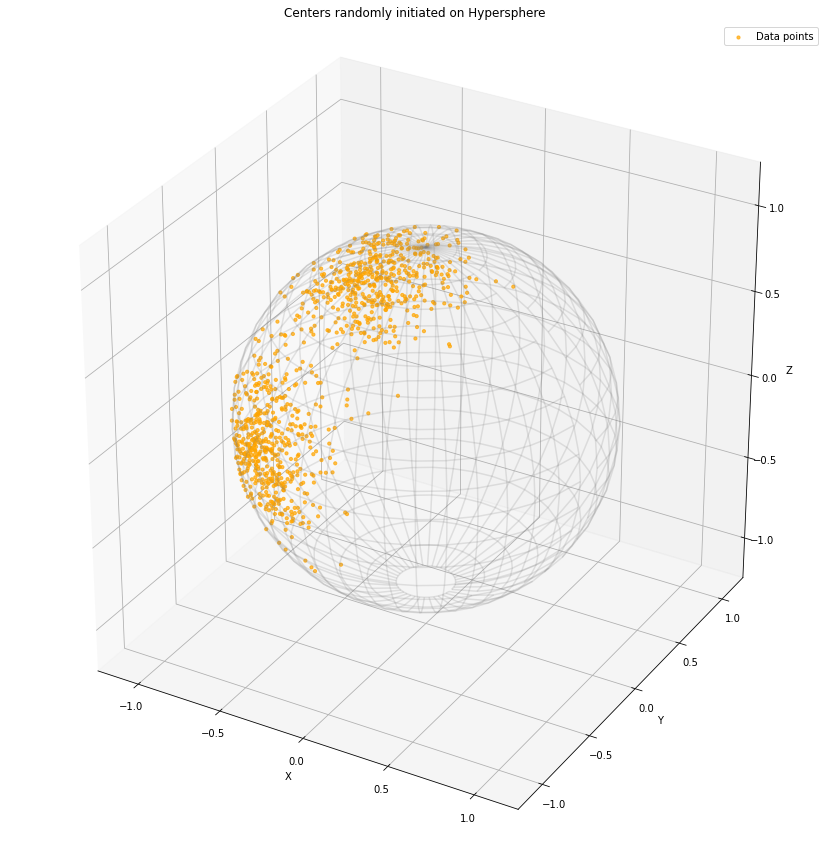

In [55]:
special_orthogonal = SpecialOrthogonal(3)
rotation1 = special_orthogonal.random_uniform()
rotation2 = special_orthogonal.random_uniform()

cluster_1 = cluster @ rotation1
cluster_2 = cluster @ rotation2

combined_cluster = gs.concatenate((cluster_1, cluster_2))

fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111, projection='3d')

ax = visualization.plot(combined_cluster, space='S2', color='orange', alpha=0.7, s=10, label='Data points')
ax.auto_scale_xyz([-1, 1], [-1, 1], [-1, 1])
ax.legend()
ax.set_title('Centers randomly initiated on Hypersphere');

## Benchmark

Once the synthetic data points have been generated on the Hypersphere, we apply RMS on it and analyze if we can cluster all the data points separately as we intend. The hyperparameter bandwidth needs to be chosen wisely since it decides the size of the $\lambda$-ball for each of the centers initiated randomly from the given input points. The tolerance parameter decides when to stop computing successive means. If the distance between two successive means is < $tol$ the mean shift computation stops and the algorithm converges to an estimation of centroids. There are two ways of initiating centroids :
1. Selecting random initial centroids from the given points itself
2. Selecting random initial centroids anywhere on the manifold

Initializing centroids from the given points could lead to an issue where all the centroids are close to each other, hence applying RMS on such centers would ultimately converge to the same (or approximately same) centroids. There's a caveat associated with the second approach as well. Initializing points randomly on the manifold could lead to a situation where there are no data points within the $\lambda$-ball of these centroids. Therefore, the Frechet Mean calculation within RMS could lead **no shift** in the means. One has to be careful about the bandwidth parameter $\lambda$ while using RMS.  


In [57]:
rms = RiemannianMeanShift(
    manifold=sphere,
    metric=metric,
    bandwidth=0.6,
    tol=1e-4,
    n_centers=2,
    init_centers="from_points",
    n_jobs=10
)
rms.fit(combined_cluster)

In [58]:
rms.centers = gs.unique(rms.centers, axis=0)
print(rms.centers)

[[-0.92477601 -0.1082823  -0.36477976]
 [-0.69232237  0.63491211  0.34289408]]


Once Mean Shift clustering is complete on the input data points, assign labels to each one based on the closest centroid.

In [59]:
point_labels = rms.predict(combined_cluster)

In [60]:
fig = plt.figure(figsize=(15, 15))

predicted_cluster1 = [combined_cluster[i] for i in range(combined_cluster.shape[0]) if (point_labels[i] == rms.centers[0]).all() ]
predicted_cluster2 = [combined_cluster[i] for i in range(combined_cluster.shape[0]) if (point_labels[i] == rms.centers[1]).all() ]


<Figure size 1080x1080 with 0 Axes>

In [61]:
predicted_cluster1 = gs.array(predicted_cluster1)
print(predicted_cluster1.shape)

predicted_cluster2 = gs.array(predicted_cluster2)
print(predicted_cluster2.shape)

(504, 3)
(496, 3)


From the above observation we see there is a slight mis-clustering of few data points. There are total 504 points in first cluster and 496 in second against the expected 500 data points in each. **Note:** the number of points in cluster may vary depending on how the initial clusters were generated. 

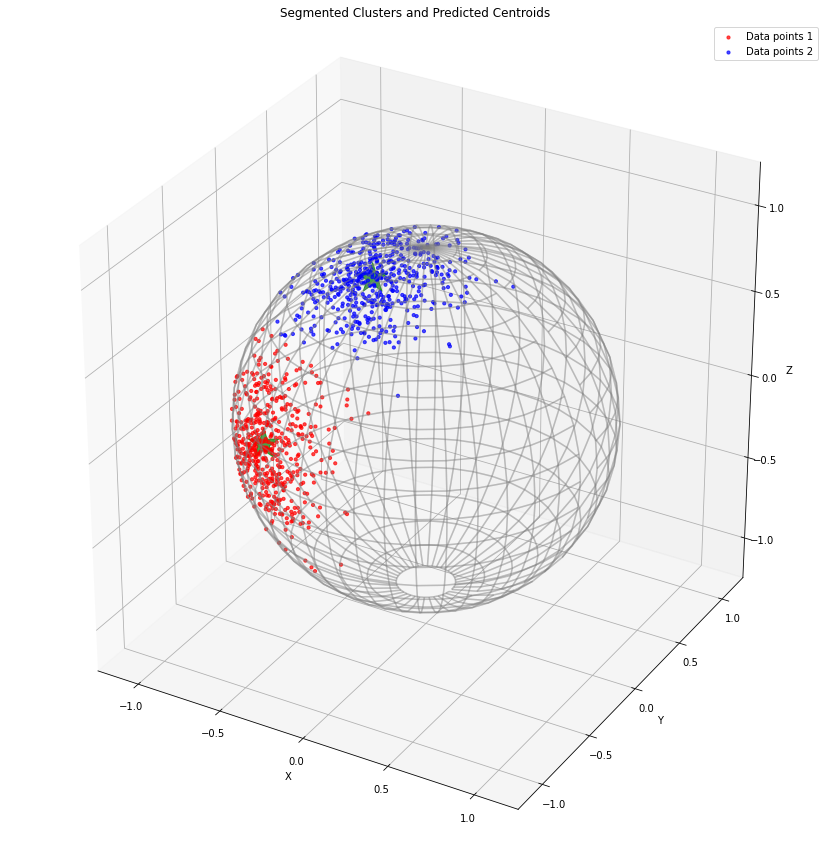

In [62]:
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111, projection='3d')

ax = visualization.plot(predicted_cluster1, space='S2', color='red', alpha=0.7, s=10, label='Data points 1')
ax = visualization.plot(predicted_cluster2, space='S2', ax=ax, color='blue', alpha=0.7, s=10, label='Data points 2')
ax = visualization.plot(rms.centers, space='S2', ax=ax, color='green', alpha=0.7, marker='*', s=1000)
ax.auto_scale_xyz([-1, 1], [-1, 1], [-1, 1])
ax.legend()
ax.set_title('Segmented Clusters and Predicted Centroids');

# 5. Real world applications of RMS

### Image segmentation using Riemannian Mean Shift algorithm

Since an image is nothing but a two-dimmensional matrix, it could be represented in an Euclidean space. For a colored image, every pixel has a RGB value therefore we define an Euclidean space of three dimmensions where each dimmension represents a color feature. 

In [63]:
data, img_paths = data_utils.load_poses()
img_path = img_paths[0]
img_path = os.path.join(data_utils.DATA_PATH, 'poses', img_path)

img = mpimg.imread(img_path)
img = img[125:220, 150:250, :]

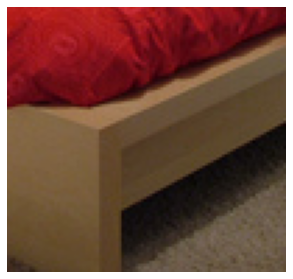

In [64]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
imgplot = ax.imshow(img)
ax.axis('off')
plt.show()

In [65]:
print(img.shape)

(95, 100, 3)


In [66]:
from geomstats.geometry.euclidean import Euclidean, EuclideanMetric

euclidean_space = Euclidean(dim=3)
euclidean_metric = EuclideanMetric(3)

rms = RiemannianMeanShift(
    manifold=euclidean_space,
    metric=euclidean_metric,
    bandwidth=0.1,
    tol=1e-4,
    n_centers=50,
    init_centers="from_points",
    n_jobs=20
)

In [67]:
input_img = img.reshape(( img.shape[0]*img.shape[1], img.shape[2] ))
print(input_img.shape)

(9500, 3)


In [69]:
rms.fit(input_img)

INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend


In [70]:
rms.centers = np.unique(rms.centers, axis=0)
print(rms.centers)

[[0.09459057 0.06748327 0.06022633]
 [0.09483506 0.06734779 0.06016561]
 [0.37891385 0.29088572 0.18609291]
 [0.43236485 0.05129981 0.08738962]
 [0.43244964 0.0513036  0.08740064]
 [0.44821694 0.35794    0.25134778]
 [0.44843698 0.358179   0.25164694]
 [0.44880682 0.35856625 0.2521433 ]
 [0.54363096 0.07333861 0.10807513]
 [0.5630319  0.07808908 0.11112469]
 [0.62342227 0.47356942 0.33350438]
 [0.62824994 0.09628841 0.1181897 ]
 [0.62834334 0.09630168 0.11819395]]


In [71]:
labelled_img = rms.predict(input_img)

In [72]:
final_img = labelled_img.reshape(( img.shape[0], img.shape[1], img.shape[2] ))
print(final_img.shape)

(95, 100, 3)


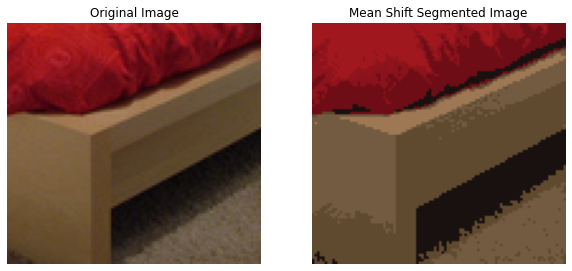

In [73]:
fig = plt.figure(figsize=(10, 5))

ax = fig.add_subplot(121)
imgplot = ax.imshow(img)
ax.set_title('Original Image');
ax.axis('off')

ax = fig.add_subplot(122)
imgplot = ax.imshow(final_img)
ax.set_title('Mean Shift Segmented Image');
ax.axis('off')

plt.show()

### Applying RMS on Optical Nerve Heads in Kendal framework

Following example in inspired from this [notebook](https://geomstats.github.io/notebooks/usecase_optic_nerve_heads_analysis_in_kendall_shape_space.html). In this usecase, we will investigate if RMS can distinguish between two groups :

1. Optical Nerve Heads that correspond to Normal eyes
2. Optical Nerve Heads that correspond to Glaucoma eyes

We import the dataset of the optical nerve heads from 22 images of Rhesus monkeys’ eyes (11 monkeys), available in [PE2015](https://geomstats.github.io/notebooks/usecase_optic_nerve_heads_analysis_in_kendall_shape_space.html#References). For each monkey, an experimental glaucoma was introduced in one eye, while the second eye was kept as control. One seeks to observe differences between the glaucoma and the control eyes. On each image, 5 anatomical landmarks were recorded:

1. Superior aspect of the retina, 
2. Side of the retina closest to the temporal bone of the skull,
3. Nose side of the retina,
4. Inferior point,
5. Optical nerve head deepest point.

Label 0 refers to a normal eye and Label 1 to an eye with glaucoma. Below is an example image which distiguishes between the two types of eye.

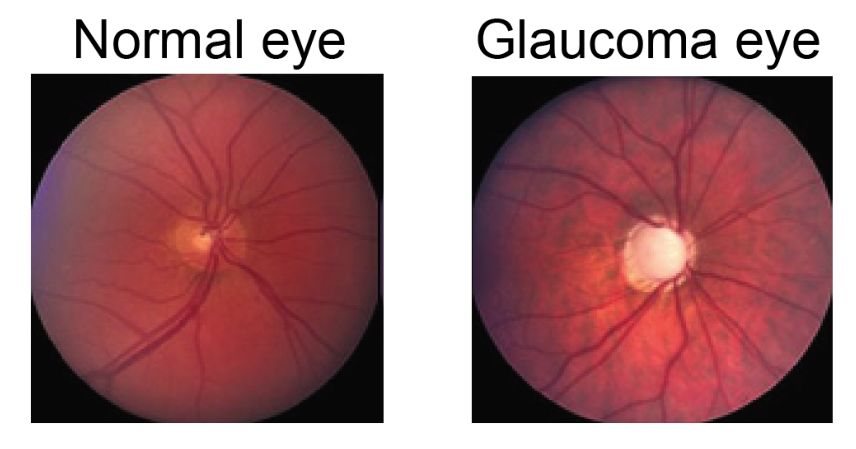

In [75]:
optic_img = mpimg.imread("optic_nerves.png")
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(111)
imgplot = ax.imshow(optic_img)
ax.axis('off')
plt.show()

We are going to visualize the first three features of Optic Nerve Heads in Kendall framework using triangular shapes.

In [43]:
nerves, labels, monkeys = data_utils.load_optical_nerves()

print(nerves.shape)
print(labels)
print(monkeys)

(22, 5, 3)
[0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1]
[ 0  0  1  1  2  2  3  3  4  4  5  5  6  6  7  7  8  8  9  9 10 10]


We first try visualizing the first three landmark features and analyze if we get clear boundaries to seperate the normal eye labels from the glaucomic eye labels.

In [45]:
landmarks = [0, 1, 2]
data = nerves[:, landmarks, :]

In [46]:
D = KendallDisk(point_type='extrinsic')

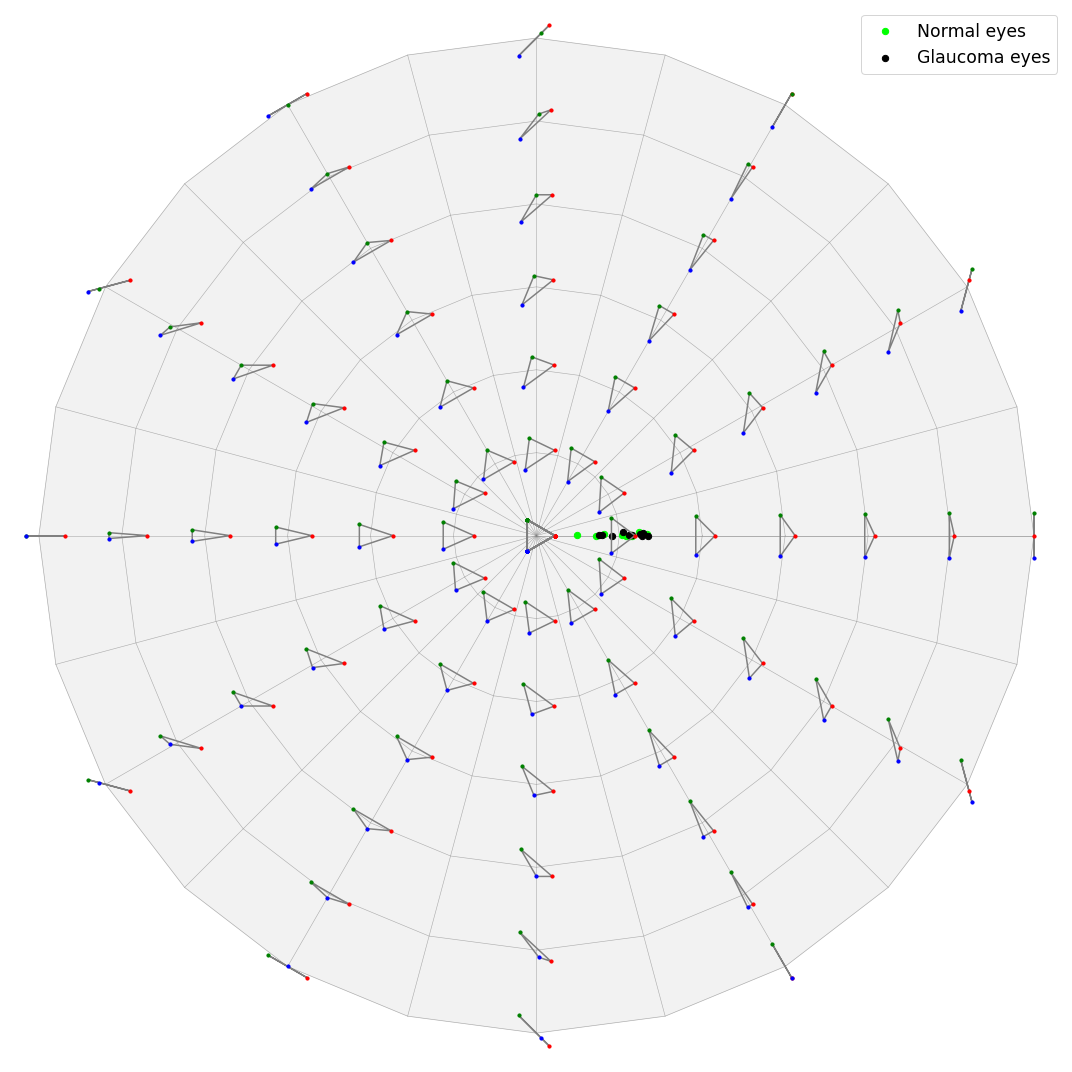

In [47]:
normal_points = gs.array([data[i] for i in range(22) if labels[i] == 0])
glaucoma_points = gs.array([data[i] for i in range(22) if labels[i] == 1])

fig = plt.figure(figsize=(15, 15))
D.draw()

D.add_points(normal_points)
D.draw_points(color=(0, 1, 0), s=40, label='Normal eyes')
D.clear_points()

glaucoma = D.add_points(glaucoma_points)
D.draw_points(color=(0, 0, 0), s=40, label='Glaucoma eyes')

plt.legend(fontsize = 'xx-large')

Since the labels on the Kendal Shape space are too close, clustering them using Riemannian Mean Shift would not yield proper clusters. Hence, we try exploring other sets of landmark until we group clusters in a way that they could be separated. After trying all possible combinations landmark set {2, 3, 4} yields data points which do no super-impose on each other. 

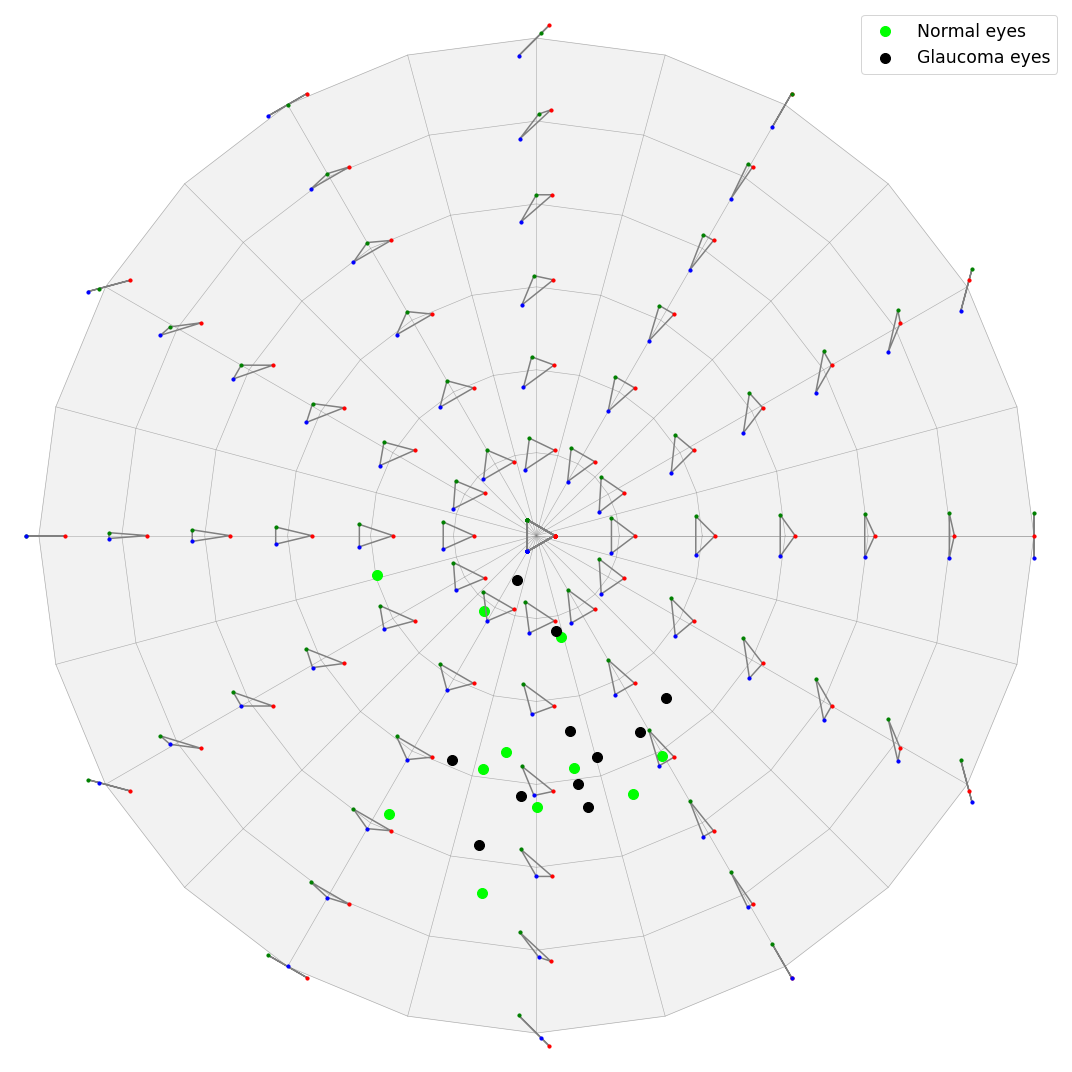

In [49]:
landmarks = [2, 3, 4]
data = nerves[:, landmarks, :]

normal_points = gs.array([data[i] for i in range(22) if labels[i] == 0])
glaucoma_points = gs.array([data[i] for i in range(22) if labels[i] == 1])

fig = plt.figure(figsize=(15, 15))
D.draw()

D.clear_points()
D.add_points(normal_points)
D.draw_points(color=(0, 1, 0), s=100, label='Normal eyes')
D.clear_points()
glaucoma = D.add_points(glaucoma_points)
D.draw_points(color=(0, 0, 0), s=100, label='Glaucoma eyes')

plt.legend(fontsize = 'xx-large')

The above labels do not give a proper separation of labels but atleast the data points are not super-imposing and could be used to apply RMS.

In [50]:
preshape_triangle_3d = PreShapeSpace(3, 3)
metric_triangle_3d = KendallShapeMetric(3, 3)

In [51]:
rms = RiemannianMeanShift(
    manifold=preshape_triangle_3d,
    metric=metric_triangle_3d,
    bandwidth=0.6,
    tol=1e-4,
    n_centers=2,
    init_centers="from_points"
)

In [52]:
rms.fit(data)

In [53]:
print(rms.centers)

[[[3820.   2600.   -147.44]
  [2620.   4080.    141.3 ]
  [2940.   2920.   -681.91]]

 [[3780.   2560.   -146.97]
  [2480.   4220.    229.27]
  [2900.   2220.   -388.  ]]]


In [54]:
predicted_labels = rms.predict(data)

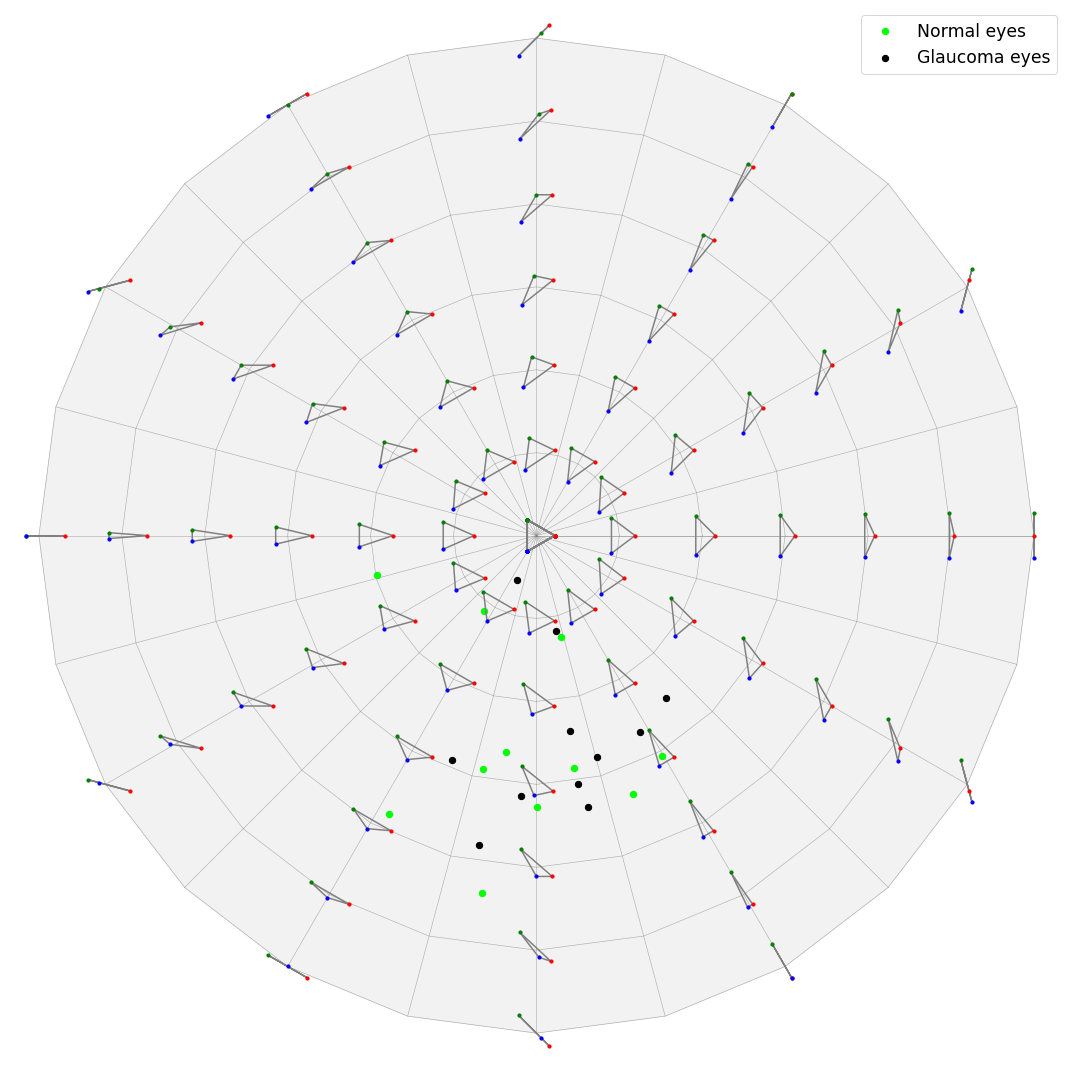

In [55]:
# fig = plt.figure(figsize=(15, 15))
# D.draw()

# D.clear_points()
# D.add_points(normal_points)
# D.draw_points(color=(0, 1, 0), s=40, label='Normal eyes')
# D.clear_points()
# glaucoma = D.add_points(glaucoma_points)
# D.draw_points(color=(0, 0, 0), s=40, label='Glaucoma eyes')

# plt.legend(fontsize = 'xx-large')

**Note:** Since, RMS is an unsupervised clustering algorithm, we would never know which true label a predicted cluster is actually representing. Hence, in the below Kendall Disk plot the labels are not set and kept as Label 1 and Label 2.

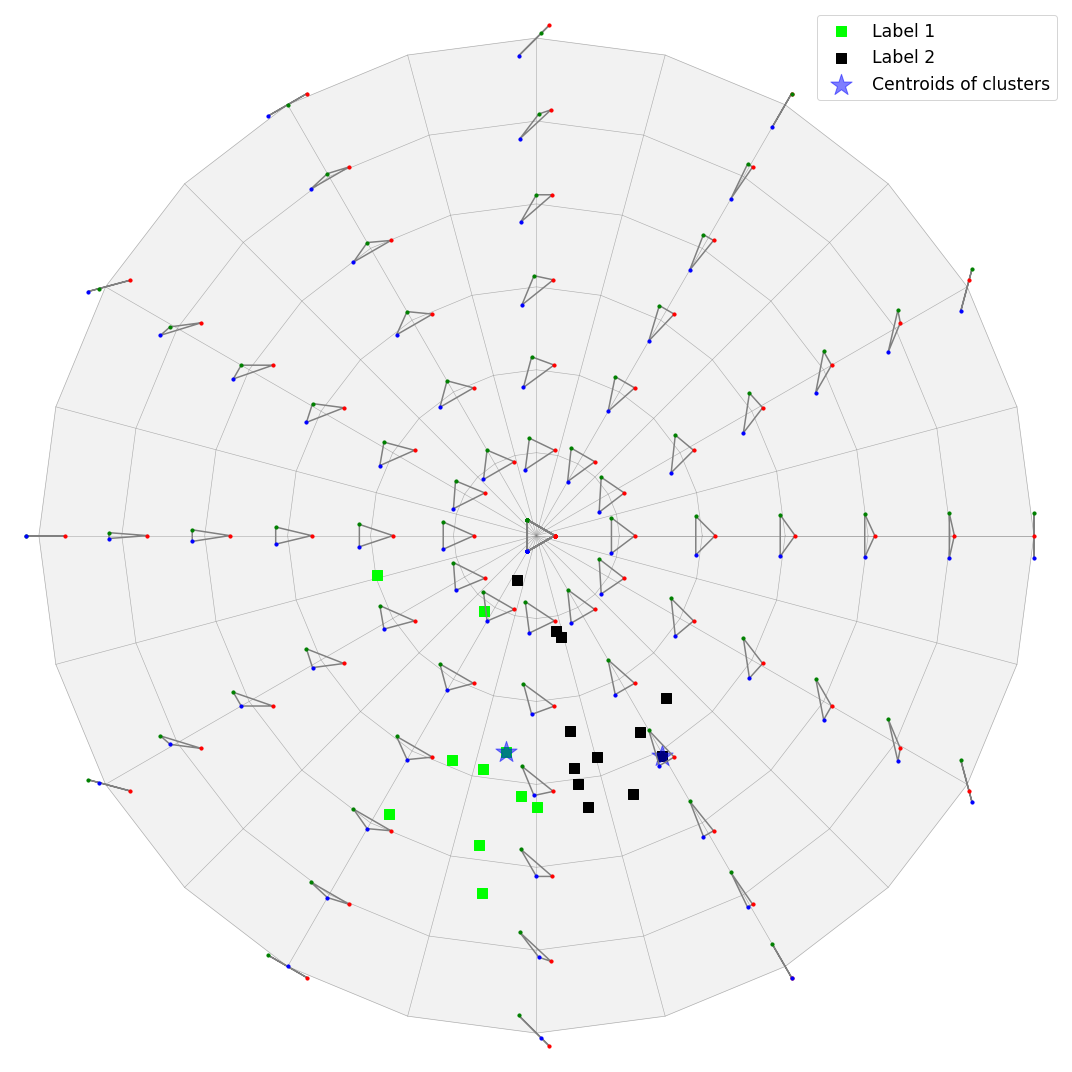

In [75]:
fig = plt.figure(figsize=(15, 15))
D.draw()

D.clear_points()
for i in range(22):
    dist = predicted_labels[i] == rms.centers[0]
    if dist.all():
        D.add_points(data[i])
D.draw_points(color=(0, 1, 0), marker='s', s=100, label='Label 1')
        
D.clear_points()
for i in range(22):
    dist = predicted_labels[i] == rms.centers[1]
    if dist.all():
        D.add_points(data[i])
D.draw_points(color=(0, 0, 0), marker='s', s=100, label='Label 2')


D.clear_points()
D.add_points(rms.centers)
D.draw_points(color=(0, 0, 1), marker='*', s=500, alpha=0.5, label='Centroids of clusters')

plt.legend(fontsize = 'xx-large')


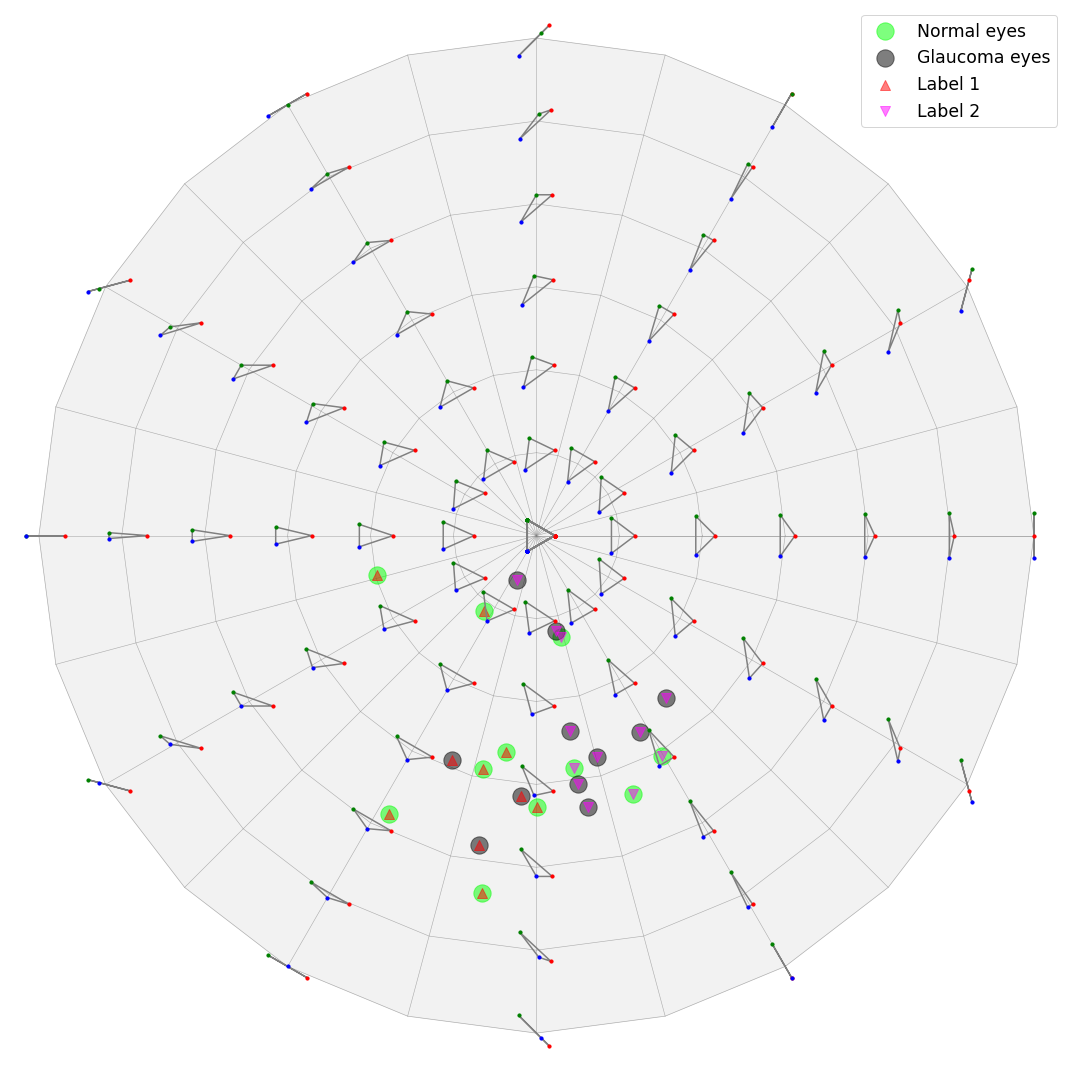

In [70]:
fig = plt.figure(figsize=(15, 15))
D.draw()

D.clear_points()
D.add_points(normal_points)
D.draw_points(color=(0, 1, 0), s=300, alpha=0.5, label='Normal eyes')
D.clear_points()
glaucoma = D.add_points(glaucoma_points)
D.draw_points(color=(0, 0, 0), s=300, alpha=0.5, label='Glaucoma eyes')

D.clear_points()
for i in range(22):
    dist = predicted_labels[i] == rms.centers[0]
    if dist.all():
        D.add_points(data[i])
D.draw_points(color=(1, 0, 0), marker='^', s=100, alpha=0.5, label='Label 1')
        
D.clear_points()
for i in range(22):
    dist = predicted_labels[i] == rms.centers[1]
    if dist.all():
        D.add_points(data[i])
D.draw_points(color=(1, 0, 1), marker='v', s=100, alpha=0.5, label='Label 2')

plt.legend(fontsize = 'xx-large')



In [84]:
rms_labels = []
count = 0

for i in range(22):
    dist = predicted_labels[i] == rms.centers[0]
    if dist.all():
        rms_labels.append(0)
        count += 1
    else:
        rms_labels.append(1)
rms_labels = gs.array(rms_labels)        

print(confusion_matrix(labels, rms_labels, labels=[0, 1]))

[[7 4]
 [3 8]]


As seen from the confusion matrix above, applying RMS on the above dataset doesn't yield good results. But this is also because we have too few data points and looking at the true labels there wasn't really a true seperation of the normal and glaucomic eyes.